<a href="https://colab.research.google.com/github/rimosoma/ML_for_healt/blob/main/lab1healt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [26]:
class SolveMinProbl:
    """
        Vettore dei Pesi Ottimali (w): Il risultato del problema di minimizzazione
        è il vettore w, di dimensione Nf×1. Ogni componente
        di questo vettore, wi, rappresenta il peso ottimale assegnato alla i-esima
        feature per prevedere il valore in y. Asse Y (w):
        Vogliamo visualizzare questi pesi ottimali. Quindi, l'asse Y deve rappresentare
        i valori di w0,w1,w2,….
        Asse X (Nf): Per identificare a quale feature appartiene ciascun peso,
        l'asse X deve fornire l'indice della feature.
    """

    def __init__(self ,y=np.ones((3,)) ,A=np.eye(3)):   #initialization with parameters useful if the user doesn't put them
        self.matr =A                                    # matrix A (known: patients and features)
        self.y = y                                      # column vector y (known: observation)
        self.Np = y.shape[0]                            # number of rows
        self.Nf =A.shape[1]                             # number of columns
        self.what = np.zeros((self .Nf,1) ,dtype=float ) # column vector what to be found
        self.min = 0                                    # square norm of the error (initially set to zero)
        self.steps = 0
        self.err = None
        return

    def plot_what(self , title="Solution"):             #method to plot what over Nf
        what=self.what                                  # retrieve what
        n=np.arange(self.Nf)                            # instantiate the x−axis
        plt.figure()                                    # instantiate the figure
        plt.plot(n,what)                                # generate the plot what versus n
        plt.xlabel("n")                                 # set the x−axis label
        plt.ylabel("w_hat(n)")                          # set the y−axis label
        plt.title(title)                                # set the title of the figure
        plt.grid()                                      # include grids
        plt.show()                                      # show the picture
        return

    def print_result(self , title ):                    # method to print the result
        print( )
        print ( title , " : ")
        print (f"    optimum weight vector: {self.what.T}")
        print (f"    total steps : {self.steps}")
        print (f"    final cost : {self.min}")

        return

    def plot_err(self, title='Square error', logy=0, logx=0):
        """
            Method to plot the squared error versus the iteration index.
            Parameters:
            title (str): The title of the plot.
            logy (int): If 1, the y-axis (error) uses a logarithmic scale.
            logx (int): If 1, the x-axis (iterations) uses a logarithmic scale.
        """
        if self.err is None or len(self.err) == 0:
            print("Errore: self.err non è stato calcolato. Niente da plottare.")
            return

        err = self.err                                  # Retrieve the matrix with the error values: [[n0, err0], [n1, err1], ...]
        plt.figure()                                    # Instantiate the figure
        x_data = err[:, 0]                              # Column 0: Iteration index (n) -> X-axis
        y_data = err[:, 1]                              # Column 1: Squared error (e(n)) -> Y-axis

        # Check scale flags and select the appropriate plotting function
        if (logy == 0) and (logx == 0):                 # Natural scales (Linear-Linear)
            plt.plot(x_data, y_data)
        elif (logy == 1) and (logx == 0):               # Semilogarithmic Y scale (Linear-Log)
            plt.semilogy(x_data, y_data)
        elif (logy == 0) and (logx == 1):               # Semilogarithmic X scale (Log-Linear)
            plt.semilogx(x_data, y_data)
        elif (logy == 1) and (logx == 1):               # Log-Log scales
            plt.loglog(x_data, y_data)

        plt.xlabel('n (Iteration Index)')               # Set the x-axis label
        plt.ylabel('e(n) (Squared Error)')              # Set the y-axis label
        plt.title(title)                                # Set the title of the figure
        plt.margins(0.01, 0.1)                          # Leave some space (margins) around the plot area
        plt.grid()                                      # Include grids
        plt.show()
        return

In [27]:
class SolveSteepestDecent(SolveMinProbl):
    """
    Steepest Descent with Exact Line Search (Optimal Step Size).
    Calculates the optimal learning rate (gamma) analytically in every iteration
    using the Hessian (H = 2*A^T*A) and the gradient (g).
    Formula: gamma = (g^T * g) / (g^T * H * g).
    Converges faster than BGD with a fixed gamma, but requires pre-calculating and using the Hessian.
    y must be a column vector. If it's not, before call the function, perform y.reshape(-1,1)'
    """
    # EDIT from original for lab1: Added 'tol' (tolerance) and increased default Nit (from 100 to 1000)
    def run(self, Nit=1000, tol=10e-10):
        self.err = np.empty((0,2) , dtype=float )        # Initialize array to store [iteration_count, total_squared_error]

        A = self.matr                                    # Retrieve the data matrix X
        y = self.y                                       # Retrieve the target vector y

        # EDIT from original for lab1: Changed initialization from random to zero for reproducible results
        # w = np.random.rand(self.Nf, 1)                 # Vecchia inizializzazione (casuale)
        w = np.zeros((self.Nf, 1))                       # Nuova inizializzazione (deterministica)


        # Pre-calculate the Hessian matrix (H)
        hessian = 2 * A.T @ A

        # Since the cost function is quadratic (least squares), the Hessian is constant
        # (it does not depend on w) and can be calculated only once outside the main loop.

        sqerr = np.inf # Inizializza l'errore per il caso in cui il loop non parta

        for i in range(Nit):                             # Loop for a fixed number of total iterations
            # Calculate the FULL Batch Gradient: = 2 * A^T * (A * w - y)
            grad = 2 * A.T @ (A @ w - y)

            # Calculate the optimal step size (gamma) using the exact line search formula for quadratic functions:
            # gamma = (g^T * g) / (g^T * H * g)
            numerator = grad.T @ grad
            denominator = grad.T @ hessian @ grad

            self.steps += 1                              # Increment the step counter

            # Stopping condition 1: Check if the denominator is zero (to prevent division error)
            if denominator < 1e-10:
                break

            # Calculate the optimal step size (gamma)
            gamma = float(numerator / denominator)

            w_new = w - gamma * grad

            # EDIT from original for lab1: Added stop condition based on 'tol' tolerance
            # Si ferma se la variazione dei pesi (norma L2) è trascurabile
            if np.linalg.norm(w_new - w) < tol:
                w = w_new # Assicura che l'ultimo w calcolato sia salvato
                break

            w = w_new

            # Calculate and store the TOTAL squared error (||Aw - y||^2) on the full dataset
            sqerr = np.linalg.norm(A @ w - y)**2
            self.err = np.append(self.err, np.array([[i, sqerr]]), axis=0)

        self.what = w                                    # Store the final optimized weights vector
        self.min = sqerr                                 # Store the final minimum total squared error

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.precision', 3)

ALL_INFO_FLAG = True

# flag to optionally drop the motor_UPDRS regressor (keeps original behaviour)
MOTOR_DROP_FLAG = False

# flag to enable/disable data shuffling before train/test split
SHUFFLE_DATA = True

# flag to enable/disable feature normalization
NORMALIZE_FEATURES = True

In [29]:
#%% Read the input csv file
plt.close('all')                                                    # close all the figures that might still be open from previous runs
X=pd.read_csv("parkinsons_updrs_av.csv")                            # read the dataset; x is a Pandas dataframe
features=list(X.columns)                                            #  list of features in the dataset
subj=pd.unique(X['subject#'])                                       # get unique patient IDs (useful to know how many subjects)
# print basic dataset info
#STARTING ANALYSIS

# Np = number of rows/patients
# Nc=number Nf of regressors + 1 (regressand total UPDRS is included)(columns/features)
Np,Nc=X.shape

if ALL_INFO_FLAG is True:
    print("---------------------------------------")
    print("---------------------------------------")
    print('✅ALL_INFO_FLAG: ON; ⬇️⬇️⬇️⬇️⬇️⬇️⬇️')
    print(" ")
    print("-------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------")
    print("-------------------🧠​ BASIC DATABASE INFO 🧠​-----------------------------")
    print("-------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------")

    print("The original dataset shape  is ",X.shape)
    print("---------------------------------------")
    print("---------------------------------------")
    print("The number of distinct patients in the dataset is ",len(subj))
    print("---------------------------------------")
    print("---------------------------------------")
    print("the original dataset features are ",len(features))
    print("---------------------------------------")
    print("---------------------------------------")
    print("HERE THE ORIGINAL FEATURES:⬇️​")

    print(features)

    #%% Have a look at the dataset
    # show summary statistics for each column (count, mean, std, min, max, percentiles)
    print("---------------------------------------")
    print("---------------------------------------")
    print("HERE THE ORIGINAL FEATURES WITH THEIR DESCRIPTIONS:⬇️​")
    print(X.describe().T)
    # show dtypes and non-null counts (helps detect missing data)
    print("---------------------------------------")
    print("---------------------------------------")
    print("HERE DEFAULT INFORMATION ABOUT THE ORIGINAL X:⬇️​")
    print(X.info())

---------------------------------------
---------------------------------------
✅ALL_INFO_FLAG: ON; ⬇️⬇️⬇️⬇️⬇️⬇️⬇️
 
-------------------------------------------------------------------------
-------------------------------------------------------------------------
-------------------🧠​ BASIC DATABASE INFO 🧠​-----------------------------
-------------------------------------------------------------------------
-------------------------------------------------------------------------
The original dataset shape  is  (990, 22)
---------------------------------------
---------------------------------------
The number of distinct patients in the dataset is  42
---------------------------------------
---------------------------------------
the original dataset features are  22
---------------------------------------
---------------------------------------
HERE THE ORIGINAL FEATURES:⬇️​
['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RA

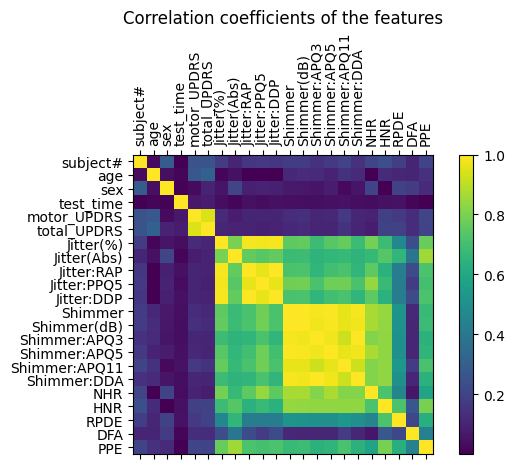

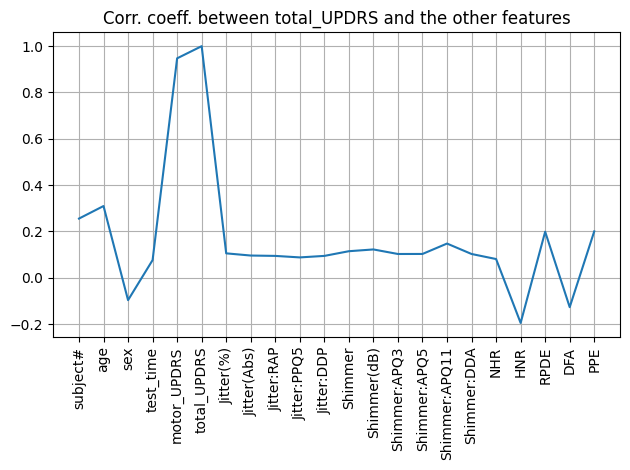

In [30]:
#%% Measure and show the covariance matrix
Xnorm=(X-X.mean())/X.std()                                          # standardize/normalize all columns (zero mean, unit std) so correlations are comparable
c=Xnorm.cov()                                                       # covariance matrix of normalized data

# show absolute covariance (correlation-like) as an image to spot strong relations
plt.figure()
plt.matshow(np.abs(c.values),fignum=0)                              # absolute value of corr.coeffs
plt.xticks(np.arange(len(features)), features, rotation=90)
plt.yticks(np.arange(len(features)), features, rotation=0)
plt.colorbar()
plt.title('Correlation coefficients of the features')
plt.tight_layout()
#plt.savefig('./corr_coeff.png')                                     # save the figure
plt.draw()
plt.figure()

# plot covariance between each feature and total_UPDRS (single column)
c.total_UPDRS.plot()
plt.grid()
plt.xticks(np.arange(len(features)),features,rotation=90)
plt.title('Corr. coeff. between total_UPDRS and the other features')
plt.tight_layout()
plt.draw()
#plt.savefig('./UPDRS_corr_coeff.png')                              # save the figure



In [31]:
#START PREPARING DATASET

print("-------------------------------------------------------------------------")
print("-------------------------------------------------------------------------")
print("-------------------🧠​ STARTING REGRESSION 🧠​-----------------------------")
print("-------------------------------------------------------------------------")
print("-------------------------------------------------------------------------")

#%% Shuffle the data, method 2
if SHUFFLE_DATA:
    Xsh = X.sample(frac=1, replace=False, random_state=310866, axis=0, ignore_index=True)
    print("---------------------------------------")
    print("---------------------------------------")
    print('✅​SHUFFLING FLAG: ON (random_state=310866)')
else:
    Xsh = X.copy()
    print("---------------------------------------")
    print("---------------------------------------")
    print('❗SHUFFLING FLAG: OFF (data kept in original order)')
    # Note: dataset may be ordered by subject/time; without shuffling, train/test split may be biased.

if ALL_INFO_FLAG is False:
    print("---------------------------------------")
    print("---------------------------------------")
    print('❗ALL_INFO_FLAG: OFF')




#%% Start working on training and test subsets

# use half the dataset for training and half for testing (simple split for the lab)
Ntr=int(Np*0.5)                                                     # number of training points
Nte=Np-Ntr                                                          # number of test points




#%% evaluate mean and st.dev. for the training data only

#is convenient to work with features with zero-mean and variance one, which typically
#reduces numerical problems and speeds up algorithm convergence (once you remove the mean
#from all the random variables, including the regressand, the model has obviously intercept
#equal to zero). Therefore we first perform normalization (or standardization or scaling) of
#the data, by removing the mean and divide by the standard deviation each random variable:

# compute training mean and std -> these will be used to normalize both train and test
# mm and ss are Series containing one value for each column (e.g., mean of age, mean of sex, etc.).
X_tr=Xsh[0:Ntr]                                                     # dataframe that contains only the training data
mm=X_tr.mean()                                                      # mean (series) of each feature
ss=X_tr.std()                                                       # standard deviation (series) of each feature
# store mean and std for the regressand (total_UPDRS) to denormalize predictions later
my=mm['total_UPDRS']                                                # mean of regressand/total UPDRS (for later use)
sy=ss['total_UPDRS']                                                # st.dev of regressand/total UPDRS (for later use)


#%% Generate the normalized/scaled training and test datasets, remove unwanted regressors
# Pandas performs "broadcasting": it automatically matches each column in Xsh
# with the corresponding mean in 'mm' and std in 'ss'.
# Effectively: (each_sample_in_Column_i - Mean_i) / Std_i for every column at once.

if NORMALIZE_FEATURES is True:
    print("---------------------------------------")
    print("---------------------------------------")
    print("✅​NORMALIZED FLAG: ON")
    # normalize full shuffled dataset using training statistics (avoid data leakage)
    Xsh_norm=(Xsh-mm)/ss                 # normalized data
else:
    print("---------------------------------------")
    print("---------------------------------------")
    print("❗​NORMALIZED FLAG: OFF")
    Xsh_norm=Xsh
# keep the normalized target separately
ysh_norm=Xsh_norm['total_UPDRS']
                         # regressand only
# drop the target and non-regressor columns before fitting
Xsh_norm=Xsh_norm.drop(['total_UPDRS','subject#', 'Shimmer:DDA', 'Jitter:DDP'],axis=1)  # regressors only


# optionally drop motor_UPDRS regressor if flag is set (keeps original code behaviour)
if MOTOR_DROP_FLAG:
    Xsh_norm=Xsh_norm.drop(['motor_UPDRS'],axis=1)                  # regressors only
    print("---------------------------------------")
    print("---------------------------------------")
    print("❗​​MOTOR DROP FLAG: ON")
else:
    print("---------------------------------------")
    print("---------------------------------------")
    print("✅MOTOR DROP FLAG: OFF")

#%% Define the list of regressors
regressors=list(Xsh_norm.columns)
Nf = len(regressors)                                                # number of regressors
print("---------------------------------------")
print("---------------------------------------")
print("The new regressors are: ",len(regressors))
#print(regressors)




# convert dataframes/series to numpy arrays for linear algebra operations
Xsh_norm=Xsh_norm.values                                            # from dataframe to Ndarray
ysh_norm=ysh_norm.values                                            # from dataframe to Ndarray
# split normalized arrays into training and test parts using earlier indices
X_tr_norm=Xsh_norm[0:Ntr]                                           # regressors for training phase
X_te_norm=Xsh_norm[Ntr:]                                            # regressors for test phase
y_tr_norm=ysh_norm[0:Ntr]                                           # regressand for training phase
y_te_norm=ysh_norm[Ntr:]                                            # regressand for test phase
print("---------------------------------------")
print("---------------------------------------")
print("The dimension of the training normalized subset are:",X_tr_norm.shape)
print("The dimension of the test normalized subset are:",X_te_norm.shape)


#FINISH PREPARATIONS

-------------------------------------------------------------------------
-------------------------------------------------------------------------
-------------------🧠​ STARTING REGRESSION 🧠​-----------------------------
-------------------------------------------------------------------------
-------------------------------------------------------------------------
---------------------------------------
---------------------------------------
✅​SHUFFLING FLAG: ON (random_state=310866)
---------------------------------------
---------------------------------------
✅​NORMALIZED FLAG: ON
---------------------------------------
---------------------------------------
✅MOTOR DROP FLAG: OFF
---------------------------------------
---------------------------------------
The new regressors are:  18
---------------------------------------
---------------------------------------
The dimension of the training normalized subset are: (495, 18)
The dimension of the test normalized subset are: (49

---------------------------------------
---------------------------------------

STEEPEST_DECENT  : 
    optimum weight vector: [[ 0.05199869 -0.01942875  0.03383148  0.94328169 -0.12391689  0.18288672
   0.06995307 -0.08471856 -0.10041712 -0.30457366  0.0833035   0.4149279
  -0.11660334 -0.01650699 -0.03727428  0.04981976 -0.04666429 -0.05867454]]
    total steps : 1000
    final cost : 44.43097173758238


/tmp/ipython-input-603894524.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma = float(numerator / denominator)


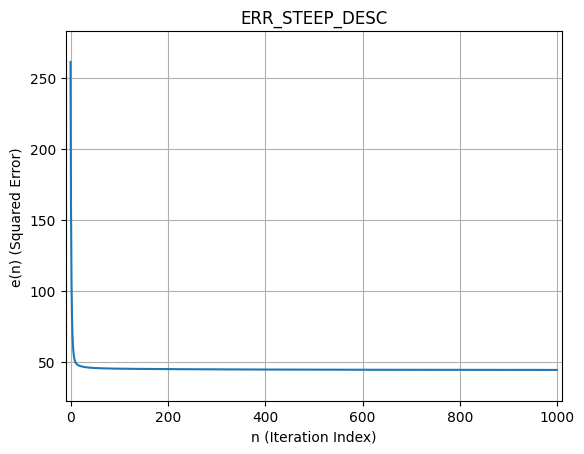

---------------------------------------
---------VETTORE DEI PESI w^-----------
---------------------------------------
Pesi LLS:  [ 0.05326537 -0.01903848  0.0345686   0.9436225  -0.14880082  0.18668702
  0.10529473 -0.11412914 -0.12660357 -0.33173373  0.03540954  0.54944274
 -0.13915071 -0.01830148 -0.0344188   0.0501144  -0.04904873 -0.04767357]
---------------------------------------
Pesi Steepest Descent:  [[ 0.05199869 -0.01942875  0.03383148  0.94328169 -0.12391689  0.18288672
   0.06995307 -0.08471856 -0.10041712 -0.30457366  0.0833035   0.4149279
  -0.11660334 -0.01650699 -0.03727428  0.04981976 -0.04666429 -0.05867454]]
---------------------------------------


In [32]:
#START REGRESSION


#FIRST METHOD
#%% LLS regression
# closed-form linear least squares: w = (X^T X)^{-1} X^T y
w_hat_LLS=np.linalg.inv(X_tr_norm.T@X_tr_norm)@(X_tr_norm.T@y_tr_norm)
y_hat_tr_norm_LLS=X_tr_norm@w_hat_LLS
y_hat_te_norm_LLS=X_te_norm@w_hat_LLS



#SECOND METHOD
#%% STEEPEST regression
# use the provided SolveSteepestDecent class -> iterative gradient-based method
s = SolveSteepestDecent(y_tr_norm.reshape(-1,1),X_tr_norm)
s.run()
print("---------------------------------------")
print("---------------------------------------")
s.print_result ("STEEPEST_DECENT")
s.plot_err("ERR_STEEP_DESC")
w_hat_steep = s.what.copy()
y_hat_tr_norm_steep=X_tr_norm@w_hat_steep
y_hat_te_norm_steep=X_te_norm@w_hat_steep


#Note that y_te_norm and y_hat_te_norm_ are normalized, and therefore the value of MSE (mean
#Square Error) does not say much to a medical doctor (what is the unit of measurement of the
#normalized mean square error?), and it is necessary to first de-normalizeˆ
#y to get a meaningful mean square error:

#%% de-normalize data realted to total-UPDRS (the regressand)
# bring predictions and true labels back to original scale: y = y_norm * sy + my
y_tr_DENORM=y_tr_norm*sy+my
y_te_DENORM=y_te_norm*sy+my

y_hat_tr_LLS_DENORM=y_hat_tr_norm_LLS*sy+my
y_hat_te_LLS_DENORM=y_hat_te_norm_LLS*sy+my

y_hat_tr_steep_DENORM=y_hat_tr_norm_steep*sy+my
y_hat_te_steep_DENORM=y_hat_te_norm_steep*sy+my



print("---------------------------------------")
print("---------VETTORE DEI PESI w^-----------")
print("---------------------------------------")

print("Pesi LLS: ", w_hat_LLS)
print("---------------------------------------")
print("Pesi Steepest Descent: ", w_hat_steep.T)
print("---------------------------------------")



#FINISH REGRESSION

            min     max       mean    std     MSE    R^2  corr_coeff
Training -6.701   9.981  4.737e-16  3.118   9.723  0.910       0.954
test     -9.905  34.807  2.206e-03  3.668  13.451  0.888       0.943


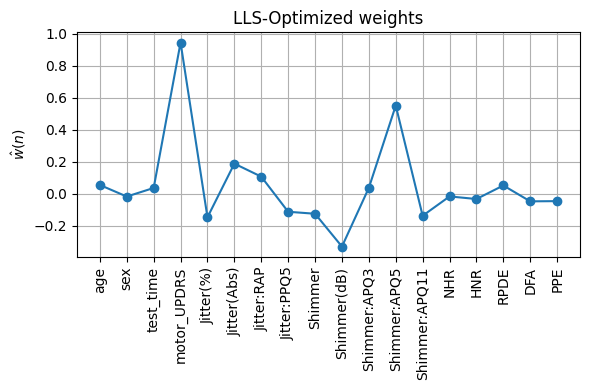

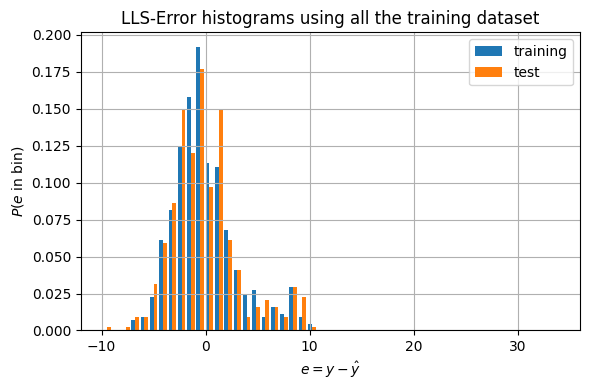

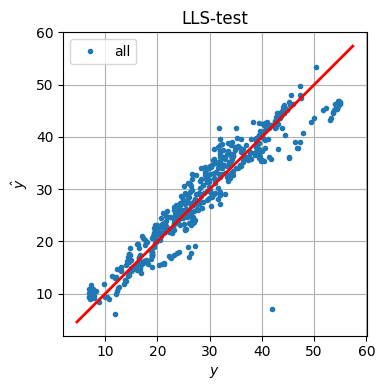

In [33]:
#START PLOTTING LLS




#%% plot the optimum weight vector for LLS
# visualize learned weights to see which regressors are important
nn=np.arange(Nf)
plt.figure(figsize=(6,4))
plt.plot(nn,w_hat_LLS,'-o')
ticks=nn
plt.xticks(ticks, regressors, rotation=90)
plt.ylabel(r'$\^w(n)$')
plt.title('LLS-Optimized weights')
plt.grid()
plt.tight_layout()
#plt.savefig('./LLS-what.png')
plt.draw()

#%% plot the error histograms for LLS
# compute residuals and show distribution for train vs test
E_tr_LLS=(y_tr_DENORM-y_hat_tr_LLS_DENORM)# errors on the training dataset
E_te_LLS=(y_te_DENORM-y_hat_te_LLS_DENORM)# errors on the test dataset
M=np.max([np.max(E_tr_LLS),np.max(E_te_LLS)])
m=np.min([np.min(E_tr_LLS),np.min(E_te_LLS)])
common_bins=np.arange(m,M,(M-m)/50)
e=[E_tr_LLS,E_te_LLS]
plt.figure(figsize=(6,4))
plt.hist(e,bins=common_bins,density=True, histtype='bar',label=['training','test'])
plt.xlabel(r'$e=y-\^y$')
plt.ylabel(r'$P(e$ in bin$)$')
plt.legend()
plt.grid()
plt.title('LLS-Error histograms using all the training dataset')
plt.tight_layout()
#plt.savefig('./LLS-hist.png')
plt.draw()


#Clearly, the error does not have a Gaussian pdf, it looks like a mixture of two Gaussian pdfs,
#and there is not much difference in the training and test subsets (which means that there is no
#overfitting)

#%% plot the regression lines for  LLS
# scatter predicted vs true on test set; ideal line is y_hat=y
plt.figure(figsize=(4,4))
plt.plot(y_te_DENORM,y_hat_te_LLS_DENORM,'.',label='all')
plt.legend()
v=plt.axis()
plt.plot([v[0],v[1]],[v[0],v[1]],'r',linewidth=2)
plt.xlabel(r'$y$')
plt.axis('square')
plt.ylabel(r'$\^y$')
plt.grid()
plt.title('LLS-test')
plt.tight_layout()
#plt.savefig('./LLS-yhat_vs_y.png')
plt.draw()

#The estimated valuesˆ
#yare close to the true values yapart from some cases in which yis very
#large andˆ
#ytakes smaller values with an error around 7-8 UPDRS points




#%% statistics of the errors of LLS
# compute many common metrics: min, max, mean, std, MSE, R^2, correlation
# on the training dataset:
E_tr_max_LLS=E_tr_LLS.max()# max error
E_tr_min_LLS=E_tr_LLS.min()# min error
E_tr_mu_LLS=E_tr_LLS.mean()# mean error
E_tr_sig_LLS=E_tr_LLS.std()# standard deviation of the error
E_tr_MSE_LLS=np.mean(E_tr_LLS**2)# mean square error
R2_tr_LLS=1-E_tr_MSE_LLS/(np.var(y_tr_DENORM))# coefficient of determination
# correlation coefficient:
c_tr_LLS=np.mean((y_tr_DENORM-y_tr_DENORM.mean())*(y_hat_tr_LLS_DENORM - y_hat_tr_LLS_DENORM.mean()))/(y_tr_DENORM.std()*y_hat_tr_LLS_DENORM.std())
# on the test dataset
E_te_max_LLS=E_te_LLS.max()# max error
E_te_min_LLS=E_te_LLS.min()# min error
E_te_mu_LLS=E_te_LLS.mean()# mean error
E_te_sig_LLS=E_te_LLS.std()# standard deviation of the error
E_te_MSE_LLS=np.mean(E_te_LLS**2)# mean square error
R2_te_LLS=1-E_te_MSE_LLS/(np.var(y_te_DENORM))# coefficient of determination
# correlation coefficient:
c_te_LLS=np.mean((y_te_DENORM-y_te_DENORM.mean())*(y_hat_te_LLS_DENORM - y_hat_te_LLS_DENORM.mean()))/(y_te_DENORM.std()*y_hat_te_LLS_DENORM.std())
cols=['min','max','mean','std','MSE','R^2','corr_coeff']
rows=['Training','test']
p=np.array([
    [E_tr_min_LLS,E_tr_max_LLS,E_tr_mu_LLS,E_tr_sig_LLS,E_tr_MSE_LLS,R2_tr_LLS,c_tr_LLS],
    [E_te_min_LLS,E_te_max_LLS,E_te_mu_LLS,E_te_sig_LLS,E_te_MSE_LLS,R2_te_LLS,c_te_LLS],
            ])

results=pd.DataFrame(p,columns=cols,index=rows)
print(results)




#FINISH PLOTTING LLS

False
            min     max       mean    std     MSE    R^2  corr_coeff
Training -6.701  10.035  4.665e-16  3.120   9.734  0.910  -1.304e-19
test     -9.598  33.123 -4.437e-03  3.633  13.198  0.891   0.000e+00


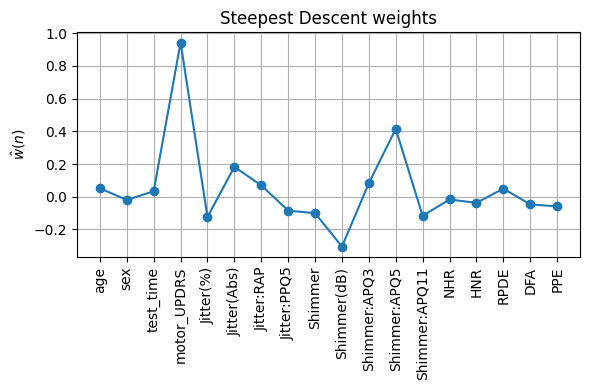

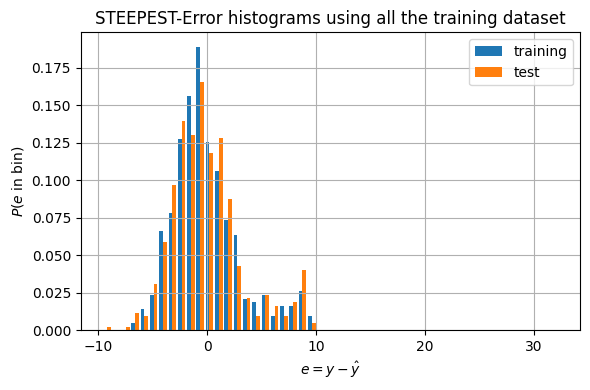

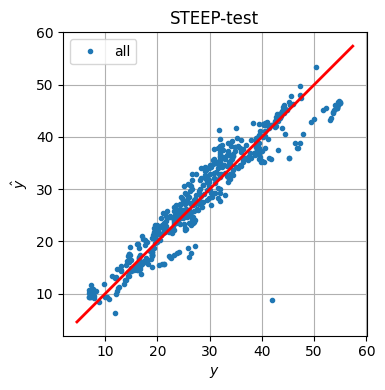

In [34]:
#START PLOTTING STEEPEST

#%% plot the optimum weight vector for Steepest (I don't use the method of lab0)
nn=np.arange(Nf)
plt.figure(figsize=(6,4))
plt.plot(nn,w_hat_steep,'-o')
ticks=nn
plt.xticks(ticks, regressors, rotation=90)
plt.ylabel(r'$\^w(n)$')
plt.title('Steepest Descent weights')
plt.grid()
plt.tight_layout()
#plt.savefig('./STEEPDESC-what.png')
plt.draw()

#%% plot the error histograms for STEEPEST
E_tr_steep =(y_tr_DENORM-y_hat_tr_steep_DENORM.ravel())# errors on the training dataset ravel perche senno era diff tra array e vettore
E_te_steep =(y_te_DENORM-y_hat_te_steep_DENORM.ravel())# errors on the test dataset

M=np.max([np.max(E_tr_steep),np.max(E_te_steep)])
m=np.min([np.min(E_tr_steep),np.min(E_te_steep)])
common_bins=np.arange(m,M,(M-m)/50)
e = [E_tr_steep, E_te_steep]
plt.figure(figsize=(6,4))
plt.hist(e,bins=common_bins,density=True, histtype='bar',label=['training','test'])
plt.xlabel(r'$e=y-\^y$')
plt.ylabel(r'$P(e$ in bin$)$')
plt.legend()
plt.grid()
plt.title('STEEPEST-Error histograms using all the training dataset')
plt.tight_layout()
#plt.savefig('./STEEPEST-hist.png')
plt.draw()


print(np.allclose(E_tr_LLS, E_tr_steep, atol=1e-6))

#%% plot the regression lines for  STEEPEST
plt.figure(figsize=(4,4))
plt.plot(y_te_DENORM,y_hat_te_steep_DENORM,'.',label='all')
plt.legend()
v=plt.axis()
plt.plot([v[0],v[1]],[v[0],v[1]],'r',linewidth=2)
plt.xlabel(r'$y$')
plt.axis('square')
plt.ylabel(r'$\^y$')
plt.grid()
plt.title('STEEP-test')
plt.tight_layout()
#plt.savefig('./STEEP-yhat_vs_y.png')
plt.draw()

#%% statistics of the errors of STEEP
# compute the same set of metrics for steepest-descent results
# on the training dataset:
E_tr_max=E_tr_steep.max()# max error
E_tr_min=E_tr_steep.min()# min error
E_tr_mu=E_tr_steep.mean()# mean error
E_tr_sig=E_tr_steep.std()# standard deviation of the error
E_tr_MSE=np.mean(E_tr_steep**2)# mean square error
R2_tr=1-E_tr_MSE/(np.var(y_tr_DENORM))# coefficient of determination
# correlation coefficient:
c_tr=np.mean((y_tr_DENORM-y_tr_DENORM.mean())*(y_hat_tr_steep_DENORM - y_hat_tr_steep_DENORM.mean()))/(y_tr_DENORM.std()*y_hat_tr_steep_DENORM.std())
# on the test dataset
E_te_max=E_te_steep.max()# max error
E_te_min=E_te_steep.min()# min error
E_te_mu=E_te_steep.mean()# mean error
E_te_sig=E_te_steep.std()# standard deviation of the error
E_te_MSE=np.mean(E_te_steep**2)# mean square error
R2_te=1-E_te_MSE/(np.var(y_te_DENORM))# coefficient of determination
# correlation coefficient:
c_te=np.mean((y_te_DENORM-y_te_DENORM.mean())*(y_hat_te_steep_DENORM - y_hat_te_steep_DENORM.mean()))/(y_te_DENORM.std()*y_hat_te_steep_DENORM.std())
cols=['min','max','mean','std','MSE','R^2','corr_coeff']
rows=['Training','test']
p=np.array([
    [E_tr_min,E_tr_max,E_tr_mu,E_tr_sig,E_tr_MSE,R2_tr,c_tr],
    [E_te_min,E_te_max,E_te_mu,E_te_sig,E_te_MSE,R2_te,c_te],
            ])

results=pd.DataFrame(p,columns=cols,index=rows)
print(results)
plt.show()